# Train Model Workflows in the Uncertainty Engine SDK

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/digiLab-ai/ue-sdk-helper/blob/main/notebooks/03_train_model_workflow.ipynb)

In this notebook, we go through how to train a model in the SDK.

## 1. Setup

We start by installing the Uncertainty Engine:

In [1]:
!pip install --quiet uncertainty-engine

And then make our imports:

In [2]:
from uncertainty_engine import Client
import os

We have different methods for interacting with our Uncertainty Engine username and password depending on whether you are using Google Colab or a local python install.

Please update the following accordingly:

In [3]:
is_google_colab = False
is_local = not is_google_colab

### Option A: Google Colab

On the left, click on the key (<img src= width="20"/>). Select `+ Add new secret`.

Then, fill in:

*   ```UE_USERNAME```: your Uncertainty Engine username (email address),
*   ```UE_PASSWORD```: your Uncertainty Engine password.

It should look like:

<img src= width="500"/>

In [4]:
if is_google_colab:
    from google.colab import userdata

    os.environ["UE_PASSWORD"] = userdata.get("UE_PASSWORD")
    os.environ["UE_USERNAME"] = userdata.get("UE_USERNAME")


### Option B: Local Use

In the *root* directory of your project, make a file named `.env`. Populate the file with:

```
UE_USERNAME='your_username'
UE_PASSWORD='your_password'
```

Next, make sure that your secrets are never git committed. You can do this by adding `.env` to the `.gitignore` file in your project root directory:
```
.env
```

Then load dotenv:

In [5]:
!pip install --quiet python-dotenv

In [6]:
from dotenv import load_dotenv
# automatically load .env in current directory
load_dotenv()

True

### Initialise your Uncertainty Engine client.

In [7]:
client = Client()

In [8]:
client.authenticate(os.environ["UE_ACCOUNT_ID"])


/var/folders/dn/cm037cfs6x91lt40wn_cx_6c0000gn/T/ipykernel_12590/2509143929.py:1: DeprecationWarning: The 'account_id' parameter is deprecated and will be removed in the next release. Fetching account ID from HTTP headers instead.
  client.authenticate(os.environ["UE_ACCOUNT_ID"])


Now we have told the Uncertainty Engine who we are, we can specify which project we are working on.

In [9]:
PROJECT_NAME = "Demos"

## 2. Train Model Workflow

We are targetting making the below workflow to train a probabilistic machine learning model. This can be created in the GUI and directly interacted with in the SDK, however in this notebook we explicitly create the workflow in the SDK.

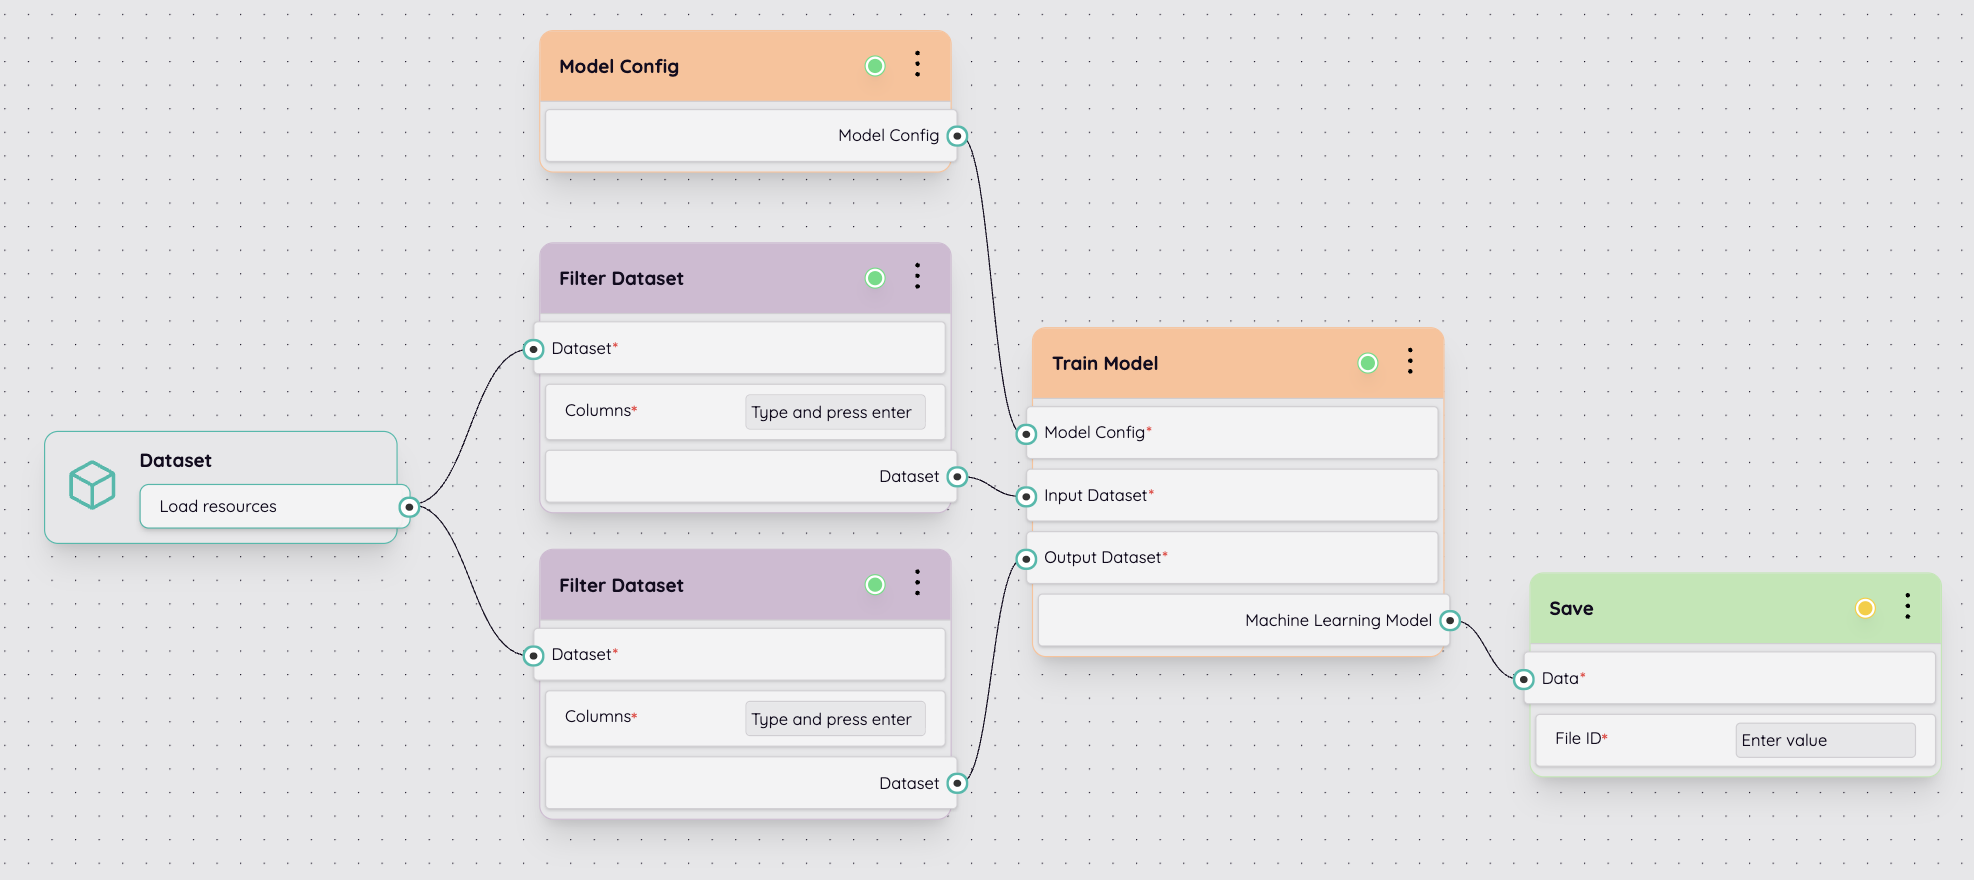

### 2.a. Making/importing helper functions

The Uncertainty Engine follows a graph-based structure. For the purpose of this notebook, we will wrap the workflow as a function to demonstrate how it can be encorporated into existing workflows.

In [10]:
# imports
from pprint import pprint
from uncertainty_engine.nodes.base import Node
from uncertainty_engine.graph import Graph
from uncertainty_engine.nodes.workflow import Workflow

import numpy as np
import pandas as pd
import io

Helper functions:

In [11]:
# The helper functions developed in earlier notebooks.

from uncertainty_engine_types import ResourceID

def get_project_id(client, project_name: str) -> str:
    """
    Get the project ID from the project name.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    return: The project ID.
    """
    projects = client.projects.list_projects()
    for project in projects:
        if project.name == project_name:
            return project.id
    raise ValueError(f"Project with name {project_name} not found.")


def get_resource_id(client, project_name: str, resource_name: str, resource_type: str) -> str:
    """
    Get the resource ID from the workflow name.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    :param resource_name: The name of the resource.
    :param resource_type: The type of the resource (e.g., 'dataset', 'model', ...).
    return: The resource ID.
    """
    project_id = get_project_id(client, project_name)
    resources = client.resources.list_resources(project_id, resource_type=resource_type)
    for resource in resources:
        if resource.name == resource_name:
            return resource.id
    raise ValueError(f"Resource with name {resource_name} not found.")

def upload_dataset(client, project_name, dataset_name, file_path=None, dataset=None, is_replace=True):
    PROJECT_ID = get_project_id(client, project_name)
    if file_path is None and dataset is not None:

        file_path = f'{dataset_name}.csv'

        df = pd.DataFrame(dataset)
        df.to_csv(file_path, index=False)
    elif file_path is None and dataset is None:
        raise ValueError("Either file_path or dataset must be provided.")
    PROJECT_ID = get_project_id(client, project_name)
    try:
        client.resources.upload(
            project_id=PROJECT_ID,
            name=dataset_name,
            resource_type="dataset",
            file_path=file_path,
        )
    except Exception as e:
        if is_replace:
            client.resources.update(
                project_id=PROJECT_ID,
                resource_id=get_resource_id(client, project_name, dataset_name, resource_type="dataset"),
                resource_type="dataset",
                file_path=file_path,
            )
        else:
            print(f"Error uploading dataset: {e}")
    print(f'Uploaded {dataset_name} to {project_name}')

def wrap_resource_id(resource_id: str):
    """
    Wrap a resource ID in a ResourceID object and return its dictionary representation.
    :param resource_id: The resource ID to wrap.
    :return: The dictionary representation of the ResourceID object."""
    return ResourceID(id=resource_id).model_dump()

def train_and_save_model_workflow(client, 
                   project_name: str,
                   dataset_name: str, 
                   input_names: list,
                   output_names: list,
                   save_model_name: str,
                   is_visualise_workflow: bool = False,
                   is_print_full_output: bool = False) -> dict:
    """
    A workflow that trains a machine learning model.
    Here, we assume all resources have already been uploaded to the cloud.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    :param dataset_name: The name of the dataset.
    :param input_names: The names of the input columns.
    :param output_names: The names of the output columns.
    :param save_model_name: The name to save the trained model as.
    :param is_visualise_workflow: Whether to print the workflow graph.
    :param is_print_full_output: Whether to print the full output of the workflow.
    :return: The response from running the workflow.
    """
    # 1. Create the graph
    graph = Graph()

    # 2. Create relevant nodes, handles, and add to graph:

    # 2.a. Model config node
    model_config = Node(
        node_name="ModelConfig",
        label="Model Config",
    )
    graph.add_node(model_config)  # add to graph
    output_config = model_config.make_handle("config")  # add handle
    
    # 2.b. Load dataset node
    load_data = Node(
        node_name="LoadDataset",
        label="Load Dataset",
        file_id=wrap_resource_id(
            get_resource_id(
                client=client,
                project_name=project_name, 
                resource_name=dataset_name, 
                resource_type='dataset')
                ),
        project_id=get_project_id(
            client=client,
            project_name=project_name
            ),
    )
    graph.add_node(load_data)  # add to graph
    dataset = load_data.make_handle("full_dataset")  # add handle
    
    # 2.b. Filter dataset node for inputs
    input_data = Node(
        node_name="FilterDataset",
        label="Input Dataset",
        columns=input_names,
        dataset=dataset,
    )
    graph.add_node(input_data)  # add to graph
    input_dataset = load_data.make_handle("input_dataset")  # add handle
    
    # 2.c. Filter dataset node for outputs
    output_data = Node(
        node_name="FilterDataset",
        label="Output Dataset",
        columns=output_names,
        dataset=dataset,
    )
    graph.add_node(output_data)  # add to graph
    output_dataset = load_data.make_handle("output_dataset")  # add handle
    
    # 2.d. Train model node
    train_model = Node(
        node_name="TrainModel",
        label="Train Model",
        config=output_config,
        inputs=input_dataset,
        outputs=output_dataset,
    )
    graph.add_node(train_model)  # add to graph
    output_model = train_model.make_handle("model")  # add handle
    
    # 2.e. Save model node
    save = Node(
        node_name="Save",
        label="Save",
        file=output_model,
        fileid=save_model_name,
    )
    graph.add_node(save)  # add to graph

    if is_visualise_workflow:
        pprint(graph.nodes)

    workflow = Workflow(
        graph=graph.nodes,
        inputs=graph.external_input,
        external_input_id=graph.external_input_id,
        requested_output={
            }
        )

    response = client.run_node(workflow)
    if is_print_full_output:
        pprint(response.model_dump())

def get_data(client,
             project_name: str,
             dataset_name: str,):
    """
    Download a dataset from the Uncertainty Engine and return it as a pandas DataFrame.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    :param dataset_name: The name of the dataset.
    :return: The dataset as a pandas DataFrame.
    """
    response = client.resources.download(
            project_id=get_project_id(client=client, project_name=project_name),
            resource_type='dataset',
            resource_id=get_resource_id(client=client, project_name=project_name,
                                resource_name=dataset_name, resource_type='dataset')
        )
    decoded = response.decode("utf-8")
    df = pd.read_csv(io.StringIO(decoded))
    return df

Visualisation:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

KEY_LIME = "#EBF38B"; INDIGO = "#16425B"; KEPPEL = "#16D5C2"
colors = [KEY_LIME, KEPPEL, INDIGO]
cmap_std = LinearSegmentedColormap.from_list("custom_map", colors)

def _infer_shape(x0, x1):
    # Sort by (x0, x1) to ensure a consistent grid ordering
    order = np.lexsort((x1, x0))
    x0s, x1s = x0[order], x1[order]
    # Unique counts along each axis
    nx = np.unique(x0s).size
    ny = np.unique(x1s).size
    return (ny, nx), order

def _shared_norm_for_column(gt, pred):
    vmin = np.nanmin([np.nanmin(gt), np.nanmin(pred)])
    vmax = np.nanmax([np.nanmax(gt), np.nanmax(pred)])
    if np.isclose(vmin, vmax):
        # Avoid zero-range norms
        eps = 1e-9 if vmax == 0 else 1e-3 * abs(vmax)
        vmin, vmax = vmin - eps, vmax + eps
    return Normalize(vmin=vmin, vmax=vmax)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# --- your palette & cmap
KEY_LIME = "#EBF38B"; INDIGO = "#16425B"; KEPPEL = "#16D5C2"
cmap_std = LinearSegmentedColormap.from_list("custom_map", [KEY_LIME, KEPPEL, INDIGO])

def _infer_shape(x0, x1):
    order = np.lexsort((np.asarray(x1), np.asarray(x0)))
    x0s, x1s = np.asarray(x0)[order], np.asarray(x1)[order]
    nx = np.unique(x0s).size
    ny = np.unique(x1s).size
    return (ny, nx), order

def _shared_norm(gt, pr):
    vmin = np.nanmin([gt.min(), pr.min()])
    vmax = np.nanmax([gt.max(), pr.max()])
    if np.isclose(vmin, vmax):
        eps = 1e-9 if vmax == 0 else 1e-3 * abs(vmax)
        vmin, vmax = vmin - eps, vmax + eps
    return Normalize(vmin=vmin, vmax=vmax)

def plot_results_grid(
    test_inputs,
    test_prediction,
    test_uncertainty,
    test_outputs,
    training_inputs=None,              # DataFrame with columns ['x0','x1'] for scatter
    input_cols=("x0", "x1"),
    output_cols=None,
    shape=None,
    cmap=cmap_std,
    suptitle=None,
    figsize_per_col=3.2,
    figsize_row=3.0,
    scatter_kwargs=None,               # to tweak training points (size, alpha, etc.)
):
    """
    Grid: rows=[Ground truth, Prediction, Uncertainty], cols=each output in output_cols.
    - Top colorbars with labels
    - Column headers (output names) placed above colorbars, just below suptitle
    - Optional white scatter points for training_inputs across all panels
    """
    import pandas as pd

    x0 = np.asarray(test_inputs[input_cols[0]])
    x1 = np.asarray(test_inputs[input_cols[1]])
    if output_cols is None:
        output_cols = list(test_outputs.columns)

    if shape is None:
        shape, order = _infer_shape(x0, x1)
        x0 = x0[order]; x1 = x1[order]
        test_outputs = test_outputs.iloc[order]
        test_prediction = test_prediction.iloc[order]
        test_uncertainty = test_uncertainty.iloc[order]
    ny, nx = shape

    X = x0.reshape(ny, nx)
    Y = x1.reshape(ny, nx)

    n_cols = len(output_cols)
    n_rows = 3
    fig_w = max(8, n_cols * figsize_per_col)
    fig_h = max(6, n_rows * figsize_row)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False, constrained_layout=True)

    row_titles = ["Ground truth", "Prediction", "Uncertainty"]

    # norms per column (GT/Pred share), uncertainty separate
    col_norms = []
    unc_norms = []
    for yname in output_cols:
        gt = np.asarray(test_outputs[yname])
        pr = np.asarray(test_prediction[yname])
        un = np.asarray(test_uncertainty[yname])
        col_norms.append(_shared_norm(gt, pr))

        umin, umax = np.nanmin(un), np.nanmax(un)
        if np.isclose(umin, umax):
            eps = 1e-9 if umax == 0 else 1e-3 * abs(umax)
            umin, umax = umin - eps, umax + eps
        unc_norms.append(Normalize(vmin=umin, vmax=umax))

    # default scatter style for training points
    skwargs = dict(s=14, c="white", edgecolors="white", linewidths=0.6, alpha=0.95, zorder=5)
    if scatter_kwargs:
        skwargs.update(scatter_kwargs)

    # plotting
    for c, yname in enumerate(output_cols):
        # Column header (place it high so it sits above the colorbar)
        axs[0, c].set_title(yname, y=1.5, fontsize=11)

        # ---- Row 0: Ground truth
        Z = np.asarray(test_outputs[yname]).reshape(ny, nx)
        im0 = axs[0, c].pcolormesh(X, Y, Z, cmap=cmap, shading="auto", norm=col_norms[c])
        cb0 = fig.colorbar(im0, ax=axs[0, c], orientation="horizontal", location="top", pad=-0.5)
        cb0.set_label(row_titles[0])

        # ---- Row 1: Prediction
        Z = np.asarray(test_prediction[yname]).reshape(ny, nx)
        im1 = axs[1, c].pcolormesh(X, Y, Z, cmap=cmap, shading="auto", norm=col_norms[c])
        cb1 = fig.colorbar(im1, ax=axs[1, c], orientation="horizontal", location="top", pad=0.)
        cb1.set_label(row_titles[1])

        # ---- Row 2: Uncertainty
        Z = np.asarray(test_uncertainty[yname]).reshape(ny, nx)
        im2 = axs[2, c].pcolormesh(X, Y, Z, cmap=cmap, shading="auto", norm=unc_norms[c])
        cb2 = fig.colorbar(im2, ax=axs[2, c], orientation="horizontal", location="top", pad=0.)
        cb2.set_label(row_titles[2])

        # overlay training inputs scatter (if provided)
        if training_inputs is not None:
            # axs[0, c].scatter(training_inputs[input_cols[0]], training_inputs[input_cols[1]], **skwargs)
            # axs[1, c].scatter(training_inputs[input_cols[0]], training_inputs[input_cols[1]], **skwargs)
            axs[2, c].scatter(training_inputs[input_cols[0]], training_inputs[input_cols[1]], label='Training data', **skwargs)

        # axis labels on left & bottom to reduce clutter
        if c == 0:
            axs[0, c].set_ylabel(input_cols[1])
            axs[1, c].set_ylabel(input_cols[1])
            axs[2, c].set_ylabel(input_cols[1])
        axs[2, c].set_xlabel(input_cols[0])

    if training_inputs is not None:
        axs[2, 0].legend(loc="upper right", frameon=True)
        axs[2, 1].legend(loc="upper right", frameon=True)
    if suptitle:
        fig.suptitle(suptitle, y=0.98, fontsize=12)

    return fig, axs


### 2.b. Data Generation

In [13]:
def make_outputs_base(X, output_names):
    """
    Compute outputs deterministically from inputs X).
    Uses simple example rules cycling over inputs:
      y0 = sin(x)
      y1 = x^2
      y2 = exp(-0.1*x)
    """
    in_cols = list(X.columns)
    df = X.copy()

    for j, name in enumerate(output_names):
        x = df[in_cols[j % len(in_cols)]].to_numpy()
        if j % 3 == 0:
            y = np.sin(x)
        elif j % 3 == 1:
            y = x**2
        else:
            y = np.exp(-0.1 * x)
        df[name] = y
    return df

def make_data(input_names, output_names, filepath, n_points=100, seed=None,
              noise_std_cycle=(0.1, 1.0, 0.05), return_arrays=False):
    """
    Generate a synthetic dataset:
      - Builds inputs (linspace, uniform, normal cycling)
      - Calls deterministic base mapping
      - Adds Gaussian noise with stds cycling in noise_std_cycle
      - Saves to CSV
    """
    rng = np.random.default_rng(seed)

    # --- Inputs (simple defaults) ---
    X = {}
    for i, name in enumerate(input_names):
        if i % 3 == 0:
            X[name] = np.linspace(0, 10, n_points)
        elif i % 3 == 1:
            X[name] = rng.uniform(-5, 5, n_points)
        else:
            X[name] = rng.normal(0, 2, n_points)
    X = pd.DataFrame(X)

    # --- Deterministic outputs (noiseless) ---
    df_noiseless = make_outputs_base(X, output_names)

    # --- Add Gaussian noise ---
    df = df_noiseless.copy()
    for j, name in enumerate(output_names):
        std = noise_std_cycle[j % len(noise_std_cycle)]
        df[name] = df_noiseless[name] + rng.normal(0, std, n_points)

    # --- Save ---
    df.to_csv(filepath, index=False)

    if return_arrays:
        return df, df[input_names].to_numpy(), df[output_names].to_numpy()
    return df

To replicate a sparse dataset, we will train with just 20 data points.

In [14]:
input_names = ["x0", "x1"] 
output_names = ["y0", "y1"]
filename = "example"
filepath = f"{filename}.csv"
n_points = 20
make_data(input_names=input_names, 
          output_names=output_names, 
          filepath=filepath,
          n_points=n_points)

,x0,x1,y0,y1
0,0.000000,3.869863,-0.094575,16.640668
1,0.526316,3.190112,0.638488,7.942040
2,1.052632,-1.601325,0.879778,4.095304
3,1.578947,2.714978,0.981247,6.799286
4,2.105263,-1.219565,0.971011,2.498560
5,2.631579,3.276678,0.465230,10.561938
6,3.157895,2.416629,-0.002631,6.084077
7,3.684211,-0.499955,-0.689907,0.025401
8,4.210526,2.978087,-0.872636,8.578835
9,4.736842,-2.831046,-0.980407,8.170128


### 2.c. Uploading Training Data to Cloud

In [15]:
upload_dataset(client=client,
               project_name=PROJECT_NAME,
               dataset_name=filename,
               file_path=filepath,
               is_replace=True)

Uploaded example to Demos


### 2.d. Training Probabilistic Machine Learning Model

In [16]:
train_and_save_model_workflow(client, 
                   project_name=PROJECT_NAME,
                   dataset_name=filename, 
                   input_names=input_names,
                   output_names=output_names,
                   save_model_name=f'{filename}_model',
                   )

## 3. Predicting with Trained Model

Since this model is saved to the cloud, we can consider how the SDK and GUI can be used together.

We can define a new test dataset and upload it:

In [17]:
x0 = np.linspace(0, 10, 50)
x1 = np.linspace(-6, 10, 50)
X0, X1 = np.meshgrid(x0, x1)
shape = X0.shape

test_inputs = {
    'x0':       X0.flatten(),
    'x1':       X1.flatten(),
}

test_outputs = make_outputs_base(pd.DataFrame(test_inputs), output_names)

In [18]:
upload_dataset(
    client=client,
    project_name=PROJECT_NAME,
    dataset_name='test_input',
    dataset=test_inputs
)

Uploaded test_input to Demos


The resources generated in this notebook (input datasets, trained model) are stored in the cloud. This means that they can be ran via the GUI if preferred.

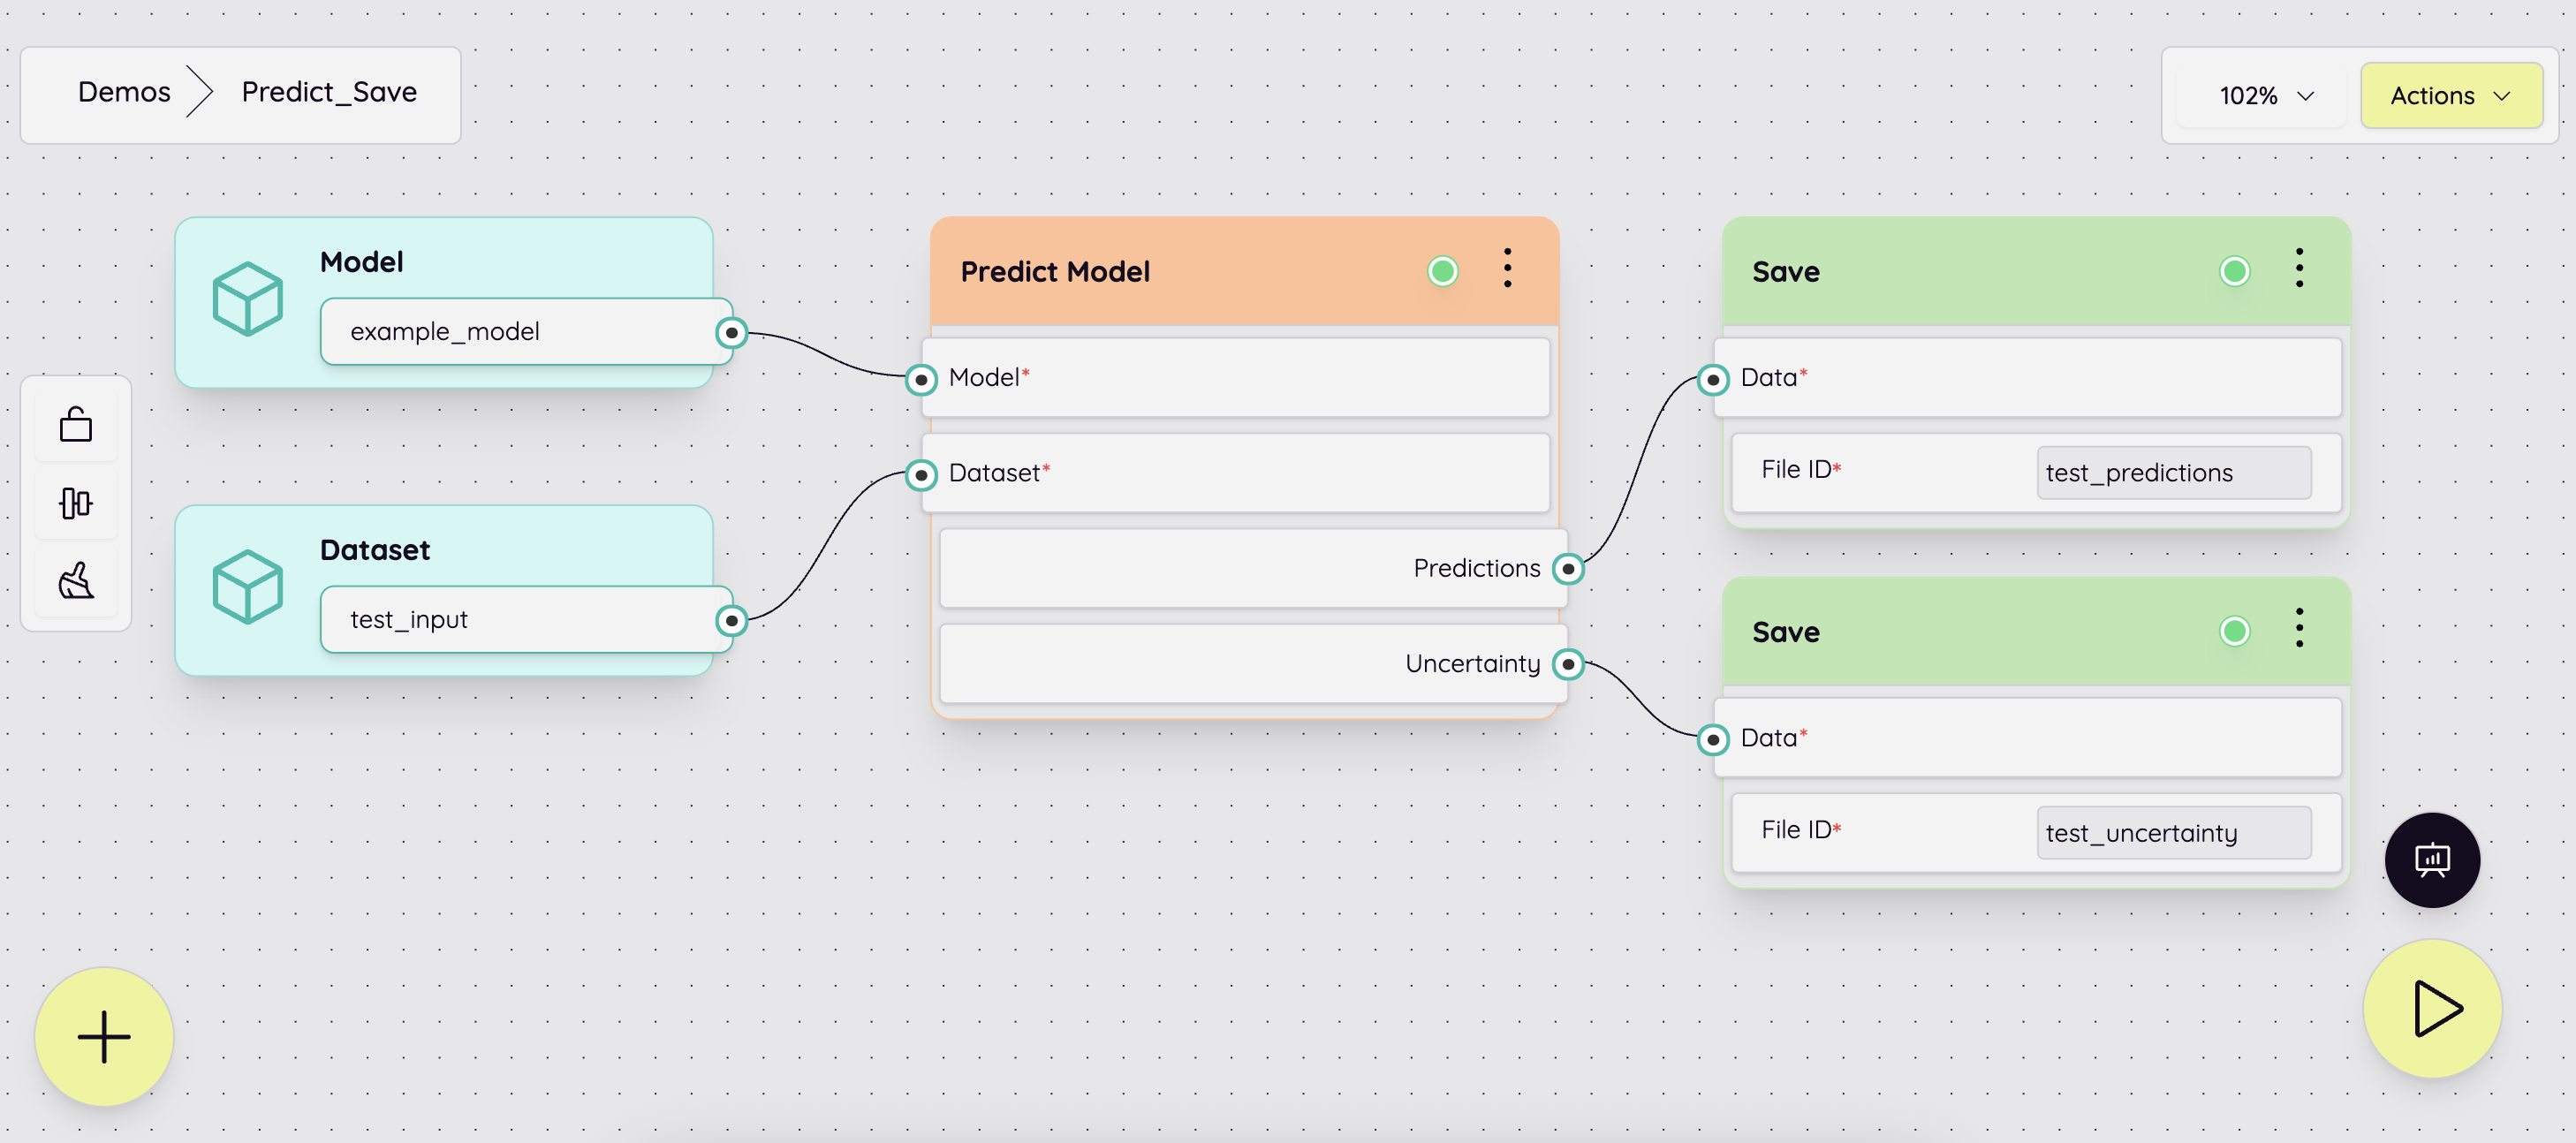

### Visualise Results

After predicting with our trained model in the cloud, we can recover the results to plot.

In [19]:
test_predictions = get_data(
    client=client,
    project_name=PROJECT_NAME,
    dataset_name='test_predictions'
)
test_uncertainty = get_data(
    client=client,
    project_name=PROJECT_NAME,
    dataset_name='test_uncertainty'
)

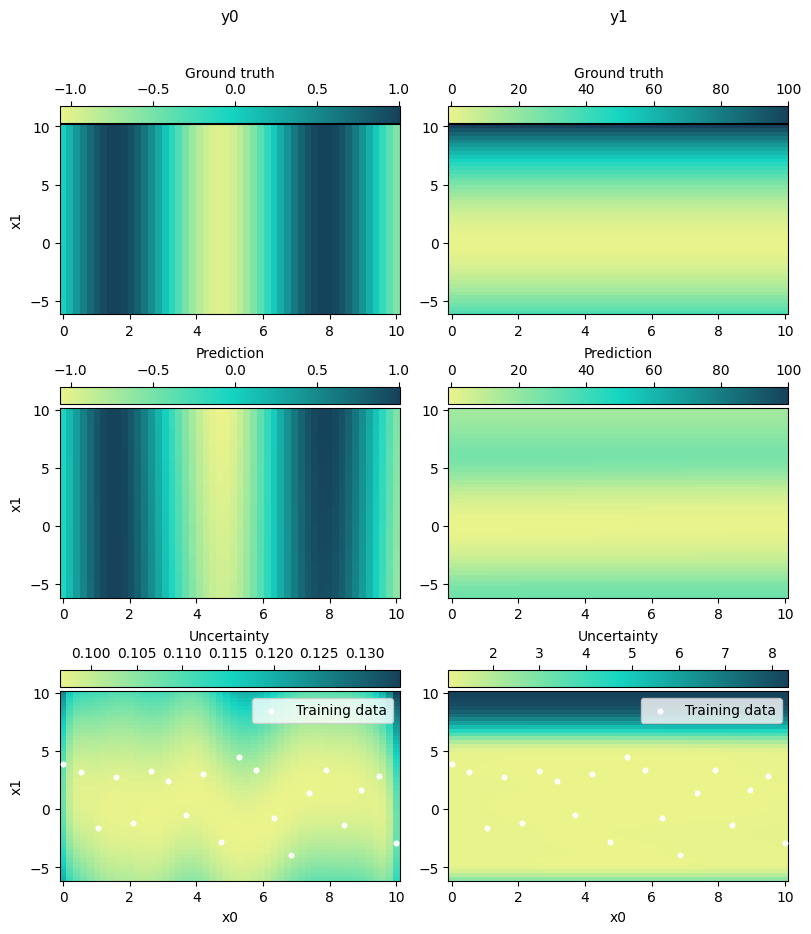

In [20]:
training_inputs = get_data(
    client=client,
    project_name=PROJECT_NAME,
    dataset_name=filename
)

fig, axs = plot_results_grid(
    test_inputs,
    test_predictions,
    test_uncertainty,
    test_outputs,
    training_inputs=training_inputs,
    input_cols=("x0", "x1"),
    output_cols=["y0", "y1"],   # or None to use all columns in test_outputs
    shape=None,                 # inferred automatically if omitted
    cmap=cmap_std,
    suptitle=""
)
plt.show()


## Discussion

In the visualised results above, good agreement was found between the ground truth and model prediction for the y0 (left hand panel) parameter but not the y1 (right hand panel). This was due to the sparse dataset in which the model was trained on. Crucially, this discrepency is exposed through the increased uncertainty in the y1 parameter.

# Conclusion.

In this notebook, we looked at writing a train model workflow in the SDK. Cloud-based resource interaction is highlighted by subsequent prediction with the trained model in the GUI. Of course, this prediction can also be performed via the SDK alone. 

The SDK gives the opportunity to make bespoke plots and visualise the results. These can also be written as *nodes* such that bespoke visualisation can be displayed in either the GUI or SDK.

Now model training can be done, further investigations can be made. The found lengthscales and model hyperparameters are saved in the model ready for closer inspection. Additionally, the *Model Config* node allows for changes to kernels to be made alongside input and output transformations. 

Success? Any problems, contact [dan.greenhouse@digilab.ai](dan.greenhouse@digilab.ai) or submit a ticket at the Help Center: [get.support.uncertaintyengine.ai](get.support.uncertaintyengine.ai).